# **Assignment: Phase Diagram and Out-of-Equilibrium Dynamics**

#### **Author:** Guillermo Abad López

#### **Date:** 17 Feb, 2025
---

## **I. Introduction**
#### **We will study the phase diagram and the out-of-equilibrium dynamics of a paradigmatic spin model. The model is defined on an open chain of spin-1/2 constituents of length $L$. The Hamiltonian is given by [1]:**

#### $$H(p,\lambda)=-\sum_{i}\left[\sigma^{z}_{i}\sigma^{z}_{i+1}+\lambda\sigma^{z}_{i}+p \left(\sigma^{z}_{i}\sigma^{z}_{i+2}+\lambda\sigma^{x}_{i}\sigma^{x}_{i+1}\right)\right].$$

#### **Key properties of the Hamiltonian:**

1. **If $p=0$, the model reduces to the standard transverse-field Ising model.**

2. **If $\lambda=1$ and $p\to\infty$, the Ising part becomes negligible, and the model is more complicated.**

3. **For $p\neq 0$, the Hamiltonian includes next-nearest-neighbor interactions.**


#### **The goal of this assignment is to analyze the phase diagram of the model in the $(p, \lambda)$ plane and to study its out-of-equilibrium dynamics. We will focus on values $p \leq 1$ to stay close to the transverse field Ising model (whose properties you can obtain by setting p = 0).**


----


## **II. Phase Diagram (5 points)**
#### **Using $TeMPy$ [2, 3], perform the following tasks:**

### 1. **Define the model in $TeMPy$** (2 points).

 In the code below, we define a new model class (here called `ExtendedIsingModel`) that extends Tenpy’s `SpinChainNNN`.

In [689]:
# ruff: noqa: RUF002, RUF003, T201, CPY001

import warnings

import numpy as np
from extended_ising_model import ExtendedIsingModel, ExtendedIsingModelSweeper, ExtIsingModelTimeEvolPlotter

warnings.filterwarnings("ignore", message="unused option", category=UserWarning)


**Lattice & Sites:**

We create a one-dimensional chain of length L, where each site is a spin‑1/2 Hilbert space.

**Hamiltonian Terms:**
- The nearest-neighbor ZZ coupling is added for every adjacent pair 
$(i, i+1)$ with a coefficient $−1$. 
- The onsite field is implemented by adding $− \lambda$ times $\sigma^z$ on every site.
- The next-nearest-neighbor ZZ coupling couples sites $i$ and $i+2$ with strength $−p$.
- The XX coupling (with strength $−p\lambda$) is added between sites $i$ and $i+1$.

**Parameter Choices:**

The model parameters are provided via a dictionary. With default values being:

- `L (int)`:  Length of the chain in terms of `site.GroupedSite`, i.e. we have ``2*L`` spin sites. Defaults to 10.

- `S (float)`: The 2S+1 local states range from m = -S, -S+1, ... +S, can take values: {0.5, 1, 1.5, 2, ...}. Defaults to 0.5.

- `p (float)`: The next-nearest neighbor strength for sigma_z and close neighbor sigma_x interactions; p=0 gives the transverse field Ising model. Defaults to 0.0.

- `lmbd (float)`: The field strength of Z, affecting also the close neighbor sigma_x interactions. Defaults to 1.0.

- `bc_MPS (str)`: The boundary conditions for the MPS simulation. Defaults to "infinite".

- `conserve (str | None)`: What should be conserved:  'best' | 'Sz' | 'parity' | None. Defaults to None.

### 2. **Characterize the phase diagram using an infinite MPS ansatz** (2 points):

#### **(a) For each $(p,\lambda)$ point, run simulations with bond dimensions $D=16$ and $D=32$.**


#### Executions:
---

In the cells below we execute several `dmrg`'s to find the ground state of the system, which will be used for the posterior plots.

(In some cases I might advance some info asked later, like `D=64`, since the simus are the same)

In [203]:
# Execute the sweep with this sweep intervals:
Ds = [1, 2, 3, 4, 5, 8, 10, 16, 32]
p_values = [1]
lmbd_values = np.linspace(0.9, 1.1, 20)

results_E5, results_xi5, results_S5 = ExtendedIsingModelSweeper.sweep_dmrg(
    Ds=Ds, p_values=p_values, lmbd_values=lmbd_values, init_state="up"
)

final DMRG state not in canonical form up to norm_tol_final=1.00e-10: norm_err=1.43e-10, calling psi.canonical_form()
final DMRG state not in canonical form up to norm_tol_final=1.00e-10: norm_err=1.03e-10, calling psi.canonical_form()
final DMRG state not in canonical form up to norm_tol_final=1.00e-10: norm_err=5.98e-10, calling psi.canonical_form()
final DMRG state not in canonical form up to norm_tol_final=1.00e-10: norm_err=4.26e-10, calling psi.canonical_form()
final DMRG state not in canonical form up to norm_tol_final=1.00e-10: norm_err=2.55e-09, calling psi.canonical_form()
final DMRG state not in canonical form up to norm_tol_final=1.00e-10: norm_err=1.69e-09, calling psi.canonical_form()
final DMRG state not in canonical form up to norm_tol_final=1.00e-10: norm_err=1.11e-08, calling psi.canonical_form()
final DMRG state not in canonical form up to norm_tol_final=1.00e-10: norm_err=6.73e-09, calling psi.canonical_form()
final DMRG state not in canonical form up to norm_tol_fi

#### Post-process results to vizualize `Energy` vs `p` and `lambda`
---

#### `P` and `lambda` from 0->2, with `D=2,4,8,16,32,64`:

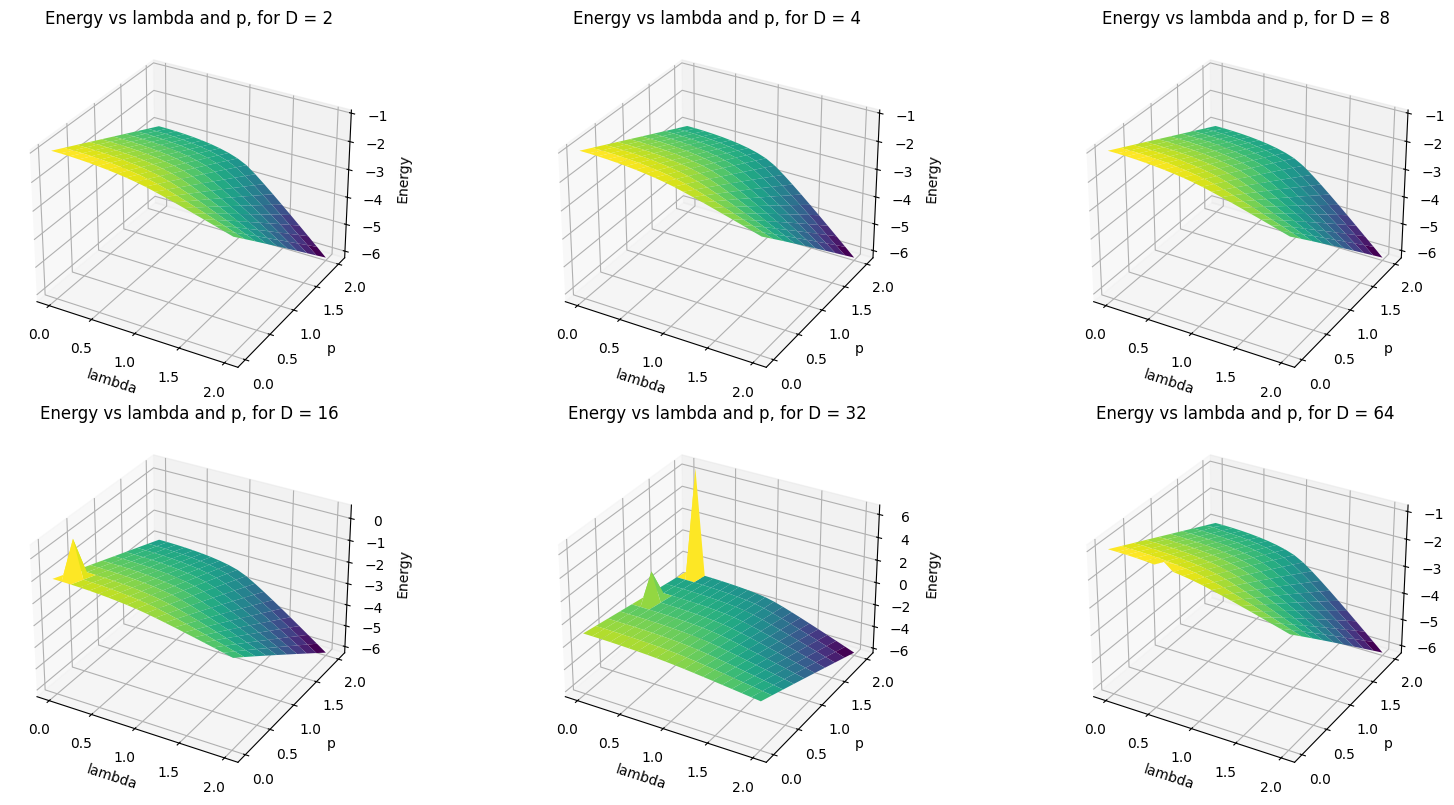

In [166]:
# Exemple of plotting the results with these sweep interval, using the Sweep Class:
Ds = [2, 4, 8, 16, 32, 64]
p_values = np.linspace(0, 2, 10)
lmbd_values = np.linspace(0.6, 2, 20)

ExtendedIsingModelSweeper.plot_sweep_vs_p_and_lambda(
    results_E3, "Energy", "Energy", Ds, p_values, lmbd_values, "viridis"
)

#### Doing more Zoom around `lambda=1`, with better axis granularity for `D=32, 64`::

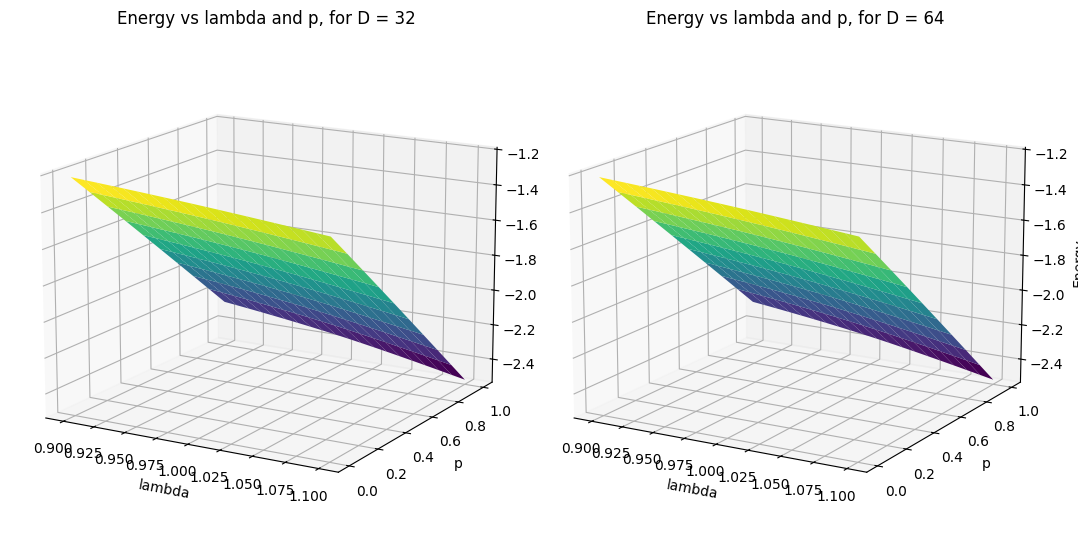

In [193]:
# Plot results with these sweep intervals:
Ds = [32, 64]
p_values = np.linspace(0, 1, 10)
lmbd_values = np.linspace(0.9, 1.1, 20)
ExtendedIsingModelSweeper.plot_sweep_vs_p_and_lambda(
    results_E4, "Energy", "Energy", Ds, p_values, lmbd_values, "viridis"
)

#### **(b) Compute and plot correlation length $\xi$ vs. $p$ and $\lambda$ for both bond dimensions. Identify regions where $D$ is insufficient to capture the physics.**

#### Same Post-process of results, but this time to vizualize the `correlation lenght` vs `p` and `lambda`
---

#### `P` and `lambda` from 0->2, with `D=2,4,8,16,32,64`:

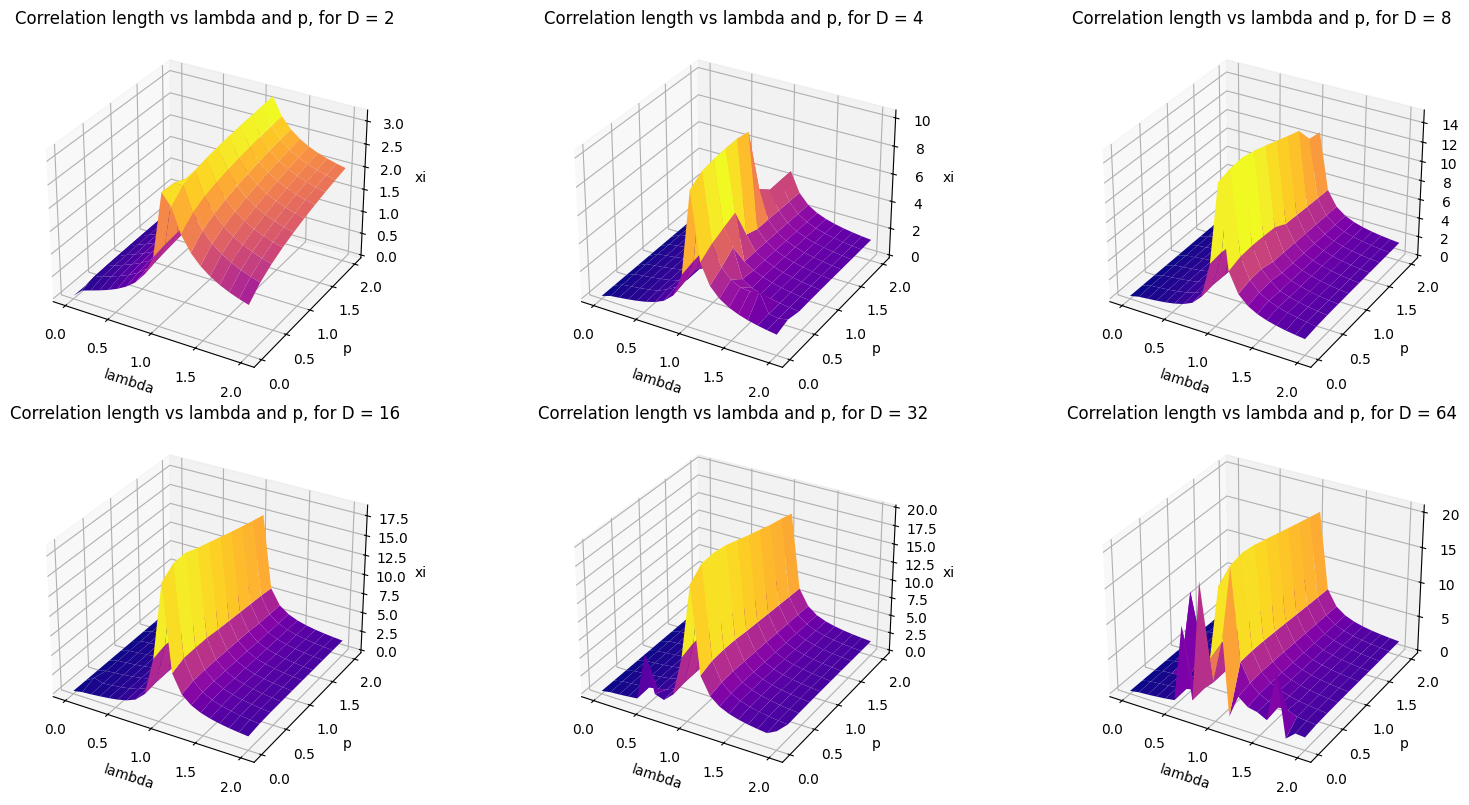

In [362]:
# Plot results with these sweep intervals:
Ds = [2, 4, 8, 16, 32, 64]
p_values = np.linspace(0, 2, 10)
lmbd_values = np.linspace(0, 2, 20)
ExtendedIsingModelSweeper.plot_sweep_vs_p_and_lambda(results_xi8, "Correlation length", "xi", Ds, p_values, lmbd_values)

#### Doing more Zoom around `lambda=1`, with better axis granularity for `D=32, 64`:

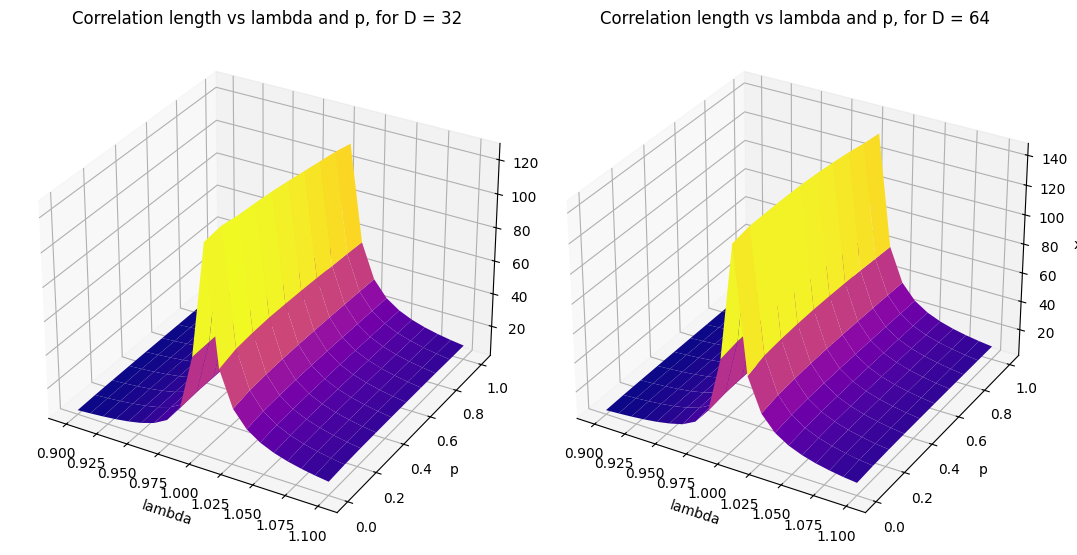

In [267]:
# Plot results with these sweep intervals:
Ds = [32, 64]
p_values = np.linspace(0, 1, 10)
lmbd_values = np.linspace(0.9, 1.1, 20)
ExtendedIsingModelSweeper.plot_sweep_vs_p_and_lambda(results_xi4, "Correlation length", "xi", Ds, p_values, lmbd_values)

#### Where its clear that in the center, `lambda ~ 1`, it keeps growing for bigger D, so smaller D's are not enough around such area.

#### **(c) Using $\xi\propto 1/\Delta$, discuss implications for the phase diagram.**


The relation:

$$\xi \propto \frac{1}{\Delta}$$
​
where $\Delta$ is the energy gap, is a key indicator of the physics. Concretely of two behaviours we can observe in our plots:

- **Gapped Phases:**
When the system is in a gapped phase, $\Delta>>0$. This implies a finite correlation length $\xi$. In these regions, all $D's>16$ should give consistent (and modest) values for $\xi$. From the plots, we can see that this is the case for `lambda`'s far from 1, regions with consistently small and converged $\xi$ for both bond dimensions.

- **Critical or Near-Critical Regions:**
At a quantum phase transition, the gap $\Delta$ closes (or becomes very small), and thus $\xi$ diverges. In practice, the iMPS approximation captures this as a very large correlation length. However, if $\xi$ is very large, a finite bond dimension $D$ imposes a cutoff (an effective finite correlation length due to entanglement truncation). Therefore, in the regions where the simulation results for different $D$'s differ significantly, this is a sign that the true correlation length (and thus the true vanishing gap) is not fully captured by the lower bond dimension. Such is the case of `lambda`'s close to 1 in our plots, areas where $\xi$ grows large and where the estimates are sensitive to $D$.

- **Summary of the Phase Diagram:**  In our model $H$, at `lambda=1` we will have a phase transition where the gap closes (or becomes very small).

### 3. **Extend simulations to larger bound dimensions $D\leq 64$** (1 point):

#### **(a) Identify regions where $\xi$ saturates with $D$ vs where it continues to grow.**

#### Post-process of results to only vizualize the `correlation lenght` vs `lambda` in a fixed `p`:
---

From the symmetry of the plot with `p` in the previous plots, we are only interested on seeing the behaviour vs `lambda`, so we can plot that for several `D`'s and compare:

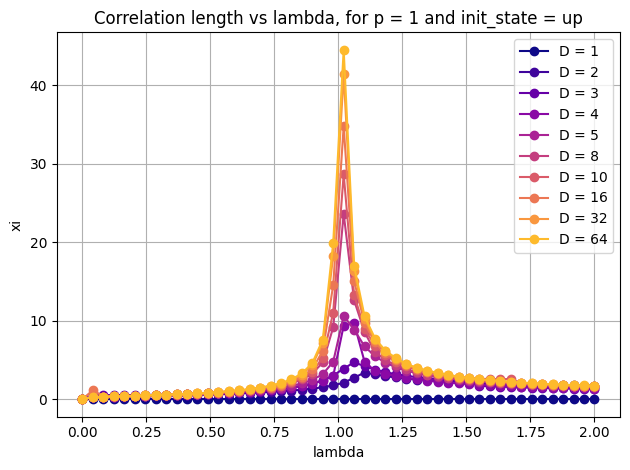

In [354]:
# Execute ploting the cut in p, and only showing dependeance in p, with the Sweep class:
Ds = [1, 2, 3, 4, 5, 8, 10, 16, 32, 64]
p_values = [1]
lmbd_values = np.linspace(0.0, 2.0, 50)

ExtendedIsingModelSweeper.plot_cut_at_fixed_p_vs_lambda(
    results_xi7, "Correlation length", "xi", Ds, p_values[0], lmbd_values, init_state="up"
)

#### We zoom on `lambda=1`, with better granularity of `lambda` and more `D`'s:

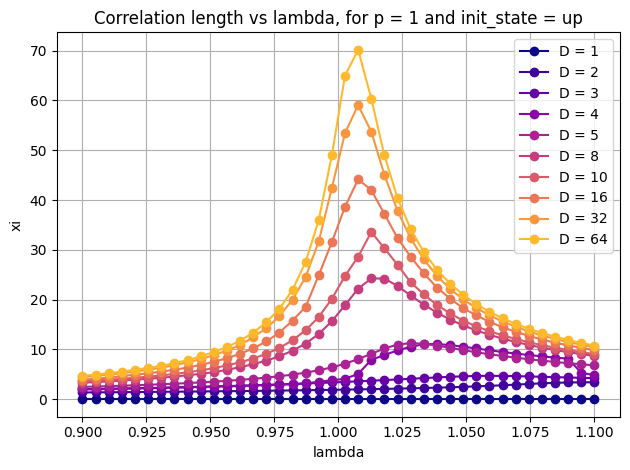

In [366]:
# Plot results with these sweep intervals:
Ds = [1, 2, 3, 4, 5, 8, 10, 16, 32, 64]
p_values = [1]
lmbd_values = np.linspace(0.9, 1.1, 40)

ExtendedIsingModelSweeper.plot_cut_at_fixed_p_vs_lambda(
    results_xi9, "Correlation length", "xi", Ds, p_values[0], lmbd_values, init_state="up"
)

#### From where now its even more clear that for `lambda` close to 1, we need a higher `D`s, since it continues to grow. Instead for `lamda` far from it, the correlation saturates quickly. Meaning that we will have a phase transition for `lambda` $\approx$ `1`.

#### Another interesting point, is seeing how the critical `lambda` moves to the right, depending on `D`, reproducing the result in Fig.3 from [4]:

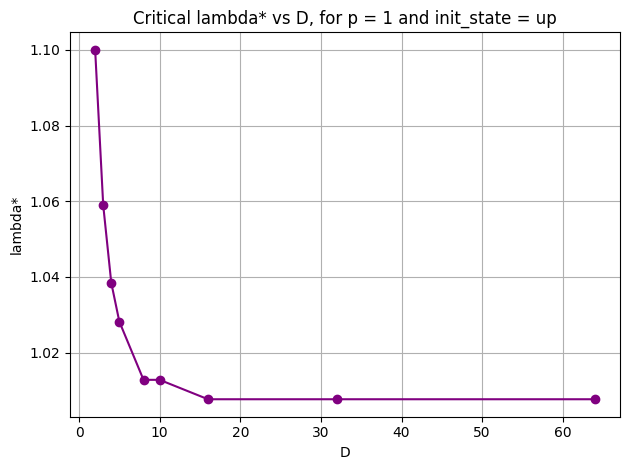

In [421]:
# Ploting critical lambda as a function of D:
Ds = [1, 2, 3, 4, 5, 8, 10, 16, 32, 64]
p_values = [1]
lmbd_values = np.linspace(0.9, 1.1, 40)


ExtendedIsingModelSweeper.plot_critical_lambda_vs_D_at_fixed_p(
    results_xi9, "Critical lambda* vs D", "lambda*", Ds, p_values[0], lmbd_values, init_state, color="purple"
)

#### **(b) Plot the half-chain entanglement entropy $S(\xi(D))$ vs $D$ and analyze its behaviour [4].**

#### Same Post-process of results, but this time to vizualize the half-chain entgl. entropy `S` vs `p` and `lambda`:
---

#### `P` and `lambda` from 0->2, with `D=2,4,8,16,32,64`:

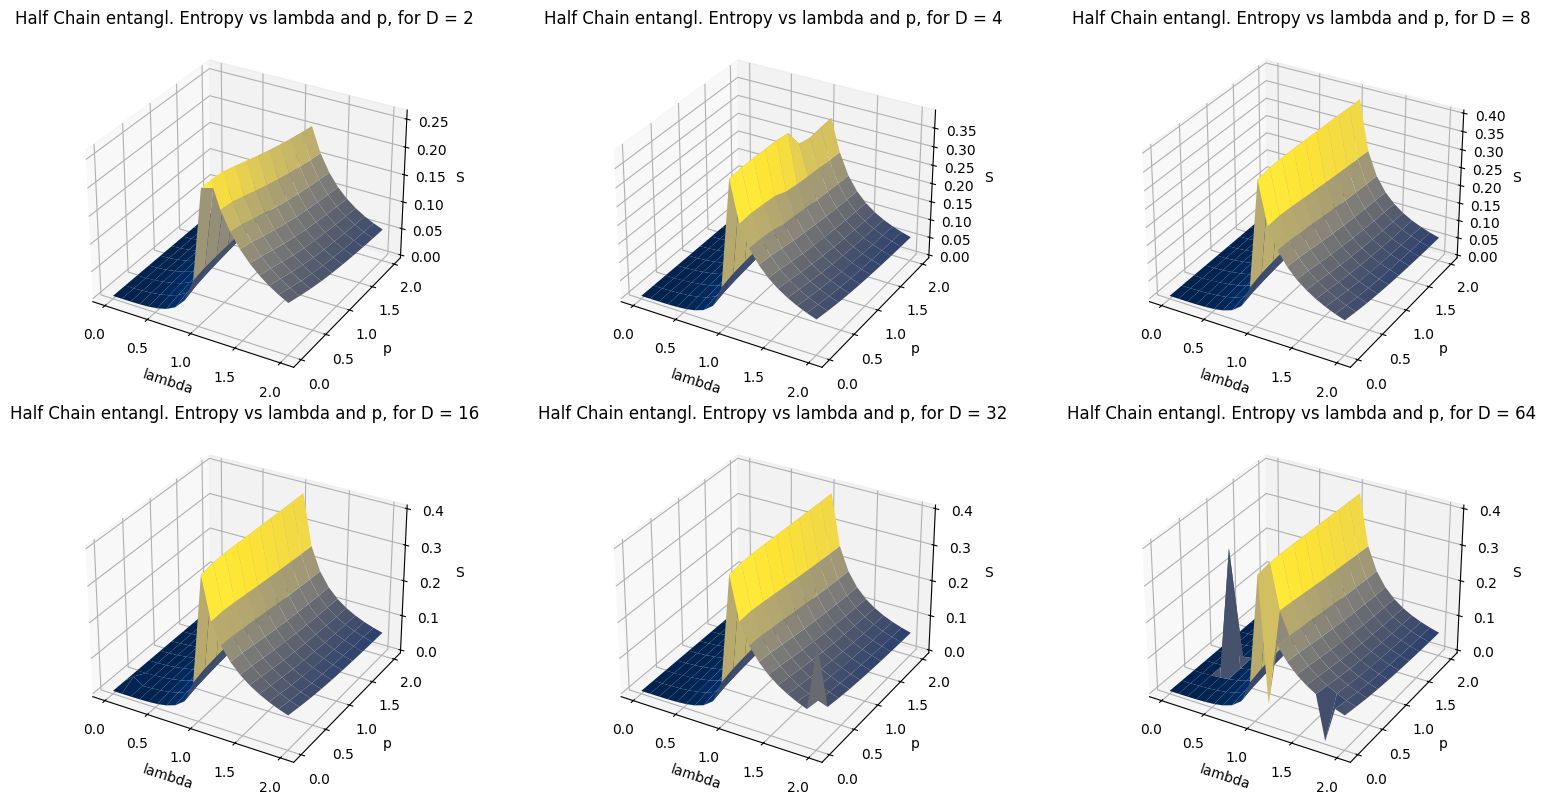

In [385]:
# Plot results with these sweep intervals:
Ds = [2, 4, 8, 16, 32, 64]
p_values = np.linspace(0, 2, 10)
lmbd_values = np.linspace(0, 2, 20)
ExtendedIsingModelSweeper.plot_sweep_vs_p_and_lambda(
    results_S8, "Half Chain entangl. Entropy", "S", Ds, p_values, lmbd_values, "cividis"
)

#### Doing more Zoom on `lambda=1`, with better granularity on the axis:

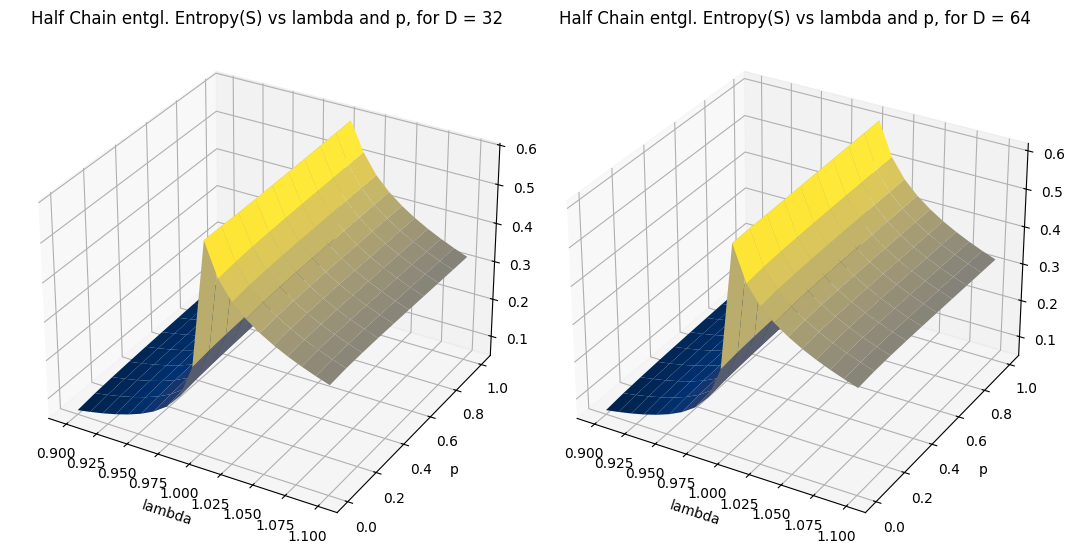

In [461]:
# Plot results with these sweep intervals:
Ds = [32, 64]
p_values = np.linspace(0, 1, 10)
lmbd_values = np.linspace(0.9, 1.1, 20)
ExtendedIsingModelSweeper.plot_sweep_vs_p_and_lambda(
    results_S4, "Half Chain entgl. Entropy(S)", "S", Ds, p_values, lmbd_values, "cividis"
)

#### And now since we also observe a symmetry with respect to `p`, as in the previous 3. (a), we are going to plot cuts, showing only the dependance with `lambda`, for the different `D`'s, to see this behaviour better:

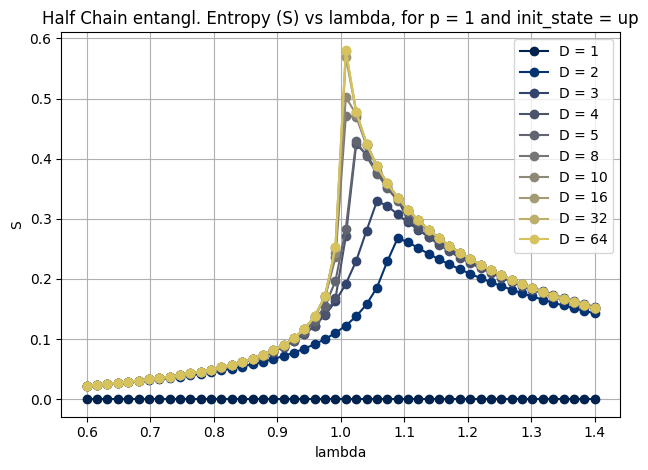

In [456]:
# Plot results with these sweep intervals:
Ds = [1, 2, 3, 4, 5, 8, 10, 16, 32, 64]
p_values = [1]
lmbd_values = np.linspace(0.6, 1.4, 50)
init_state = "up"


ExtendedIsingModelSweeper.plot_cut_at_fixed_p_vs_lambda(
    results_S6, "Half Chain entangl. Entropy (S)", "S", Ds, p_values[0], lmbd_values, init_state, color="cividis"
)

#### Obtaining a very similar result to subfigure (a), from Fig. 2 in [4].

#### And zooming in, for a better granularity of the behaviour vs lambda, looks like:

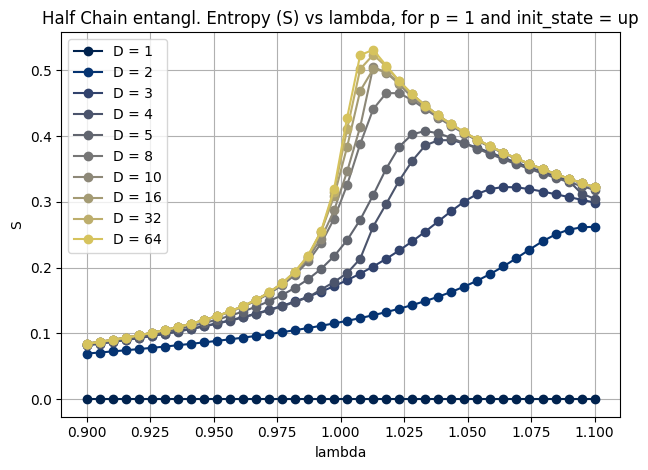

In [455]:
# Plot results with these sweep intervals:
Ds = [1, 2, 3, 4, 5, 8, 10, 16, 32, 64]
p_values = [1]
lmbd_values = np.linspace(0.9, 1.1, 40)


ExtendedIsingModelSweeper.plot_cut_at_fixed_p_vs_lambda(
    results_S9, "Half Chain entangl. Entropy (S)", "S", Ds, p_values[0], lmbd_values, init_state, color="cividis"
)

From [4], we can infere that in critical regions, the finite-entanglement scaling theory predicts that the entanglement entropy is bounded by:
$$S = a + b \log D = c \log \xi + cont, $$
And since the finite bond dimension imposes an effective finite correlation length, one can expect:

- **Gapped Phases:** $S$ will quickly saturate with increasing $D$ because the true ground state has only limited entanglement.

- **Critical Phases:** $S$ will continue to grow (approximately logarithmically) with $D$. More precisely, since the effective $\xi$ grows with $D$ in a critical system, $S$ will also show a logarithmic dependence on $D$.



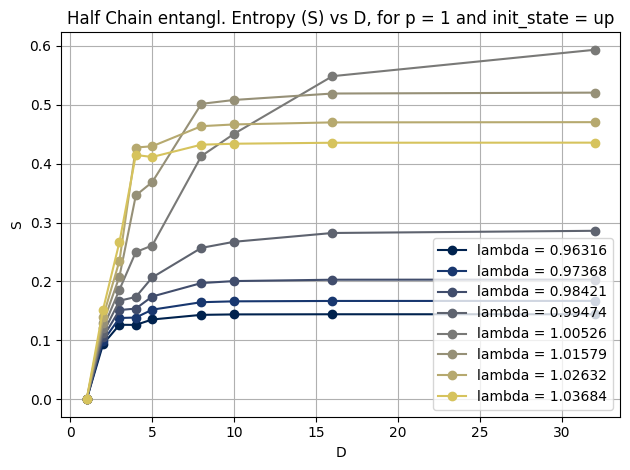

In [388]:
# Example of ploting results against D, for fixed p and lambda values, using the Sweeper class:
Ds = [1, 2, 3, 4, 5, 8, 10, 16, 32]
p_values = [1]
lmbd_values = np.linspace(0.9, 1.1, 20)[6:-6:1]


ExtendedIsingModelSweeper.plot_vs_D_at_fixed_p_and_lambdas(
    results_S5, "Half Chain entangl. Entropy (S) vs D", "S", Ds, p_values[0], lmbd_values, init_state, color="cividis"
)

#### Where clearly, for the `lambda` closer to 1, we got a logarithmic grow (Critical phase), while the gapped phases saturate faster into a const. Same results from Fig.1 in [4], but without an exponential axis of `D`, but a linear one here.

#### So for this case, the one that has not Plateaud (grey higher one), would need a higher `D`, for simulating it correctly.

#### Further thoughts:
---

- In **gapped regions**, both $\xi$ and $S$ tend to saturate as $D$ increases.

- In **critical regions**, you expect to see:

    - $\xi$ increases significantly with $D$, reflecting the divergence of the true correlation length.

    - $S$ grows approximately as $\propto \frac{c}{6} \log \xi $. In practice, plotting $S$ versus $\log\xi$ should yield a straight line whose slope gives an estimate of the central charge $c$.

    - When you plot $S$ vs. $D$ if $S$ continues to increase (rather than plateauing), it is an indication that the bond dimension is still limiting the amount of entanglement captured and that the system is near a critical point.

#### This can also seen in this other plot, where we check the Correlation lenght `Xi` as a function of `D`, where for the critical `lambda`, should keep increasing for bigger `D`'s, while for the rest, should get bounded into a plato, since no more entanglement is needed:

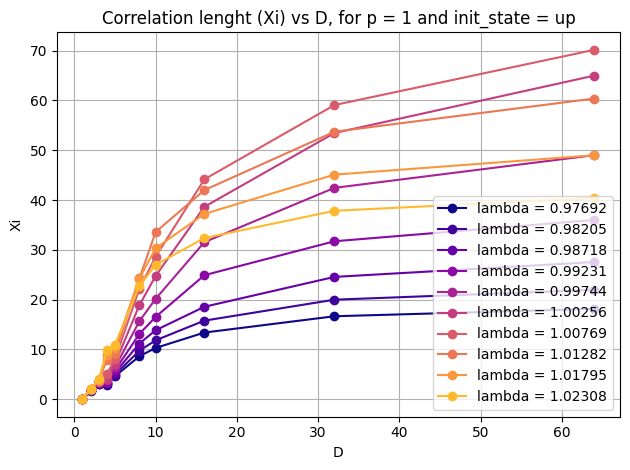

In [462]:
# # Plot results with these sweep intervals:
Ds = [1, 2, 3, 4, 5, 8, 10, 16, 32, 64]
p_values = [1]
lmbd_values = np.linspace(0.9, 1.1, 40)[15:-15:1]


ExtendedIsingModelSweeper.plot_vs_D_at_fixed_p_and_lambdas(
    results_xi9, "Correlation lenght (Xi) vs D", "Xi", Ds, p_values[0], lmbd_values, init_state, color="plasma"
)

#### where we can see how they all start similar to an exponential, since from Fig. 5 in [4] we expect $\xi \propto a D^k$. But as `D` increases then they start getting bounded, concretely the closer `lambda` is to the critical `lambda`, the later the bound starts (needing a higher correlation in the end).

---
---
---

## **III. Out-of-Equilibrium Dynamics (5 points)**
#### **Implement the quantum quench protocol using $TeMPy$**:


### 1. **Quench from a product state using (~~the iTEBD~~) an MPO time evolution algorithm**:

#### **(a) Initialize all spins in $|+\rangle$ state (along x-axis)**.


In [691]:
model_params = {"L": 2, "S": 0.5, "p": 0.5, "lmbd": 1.0, "bc_MPS": "infinite", "conserve": None}
model = ExtendedIsingModel(model_params)

# Get an initial ansatz for the model:
state = model.get_plus_ansatz("plus")

INFO    : ExtendedIsingModel: reading 'bc_MPS'='infinite'
INFO    : ExtendedIsingModel: reading 'S'=0.5
INFO    : ExtendedIsingModel: reading 'conserve'=None
INFO    : ExtendedIsingModel: reading 'L'=2
INFO    : ExtendedIsingModel: reading 'Jx'=-2.0
INFO    : ExtendedIsingModel: reading 'Jy'=0
INFO    : ExtendedIsingModel: reading 'Jz'=-4
INFO    : ExtendedIsingModel: reading 'Jxp'=0
INFO    : ExtendedIsingModel: reading 'Jyp'=0
INFO    : ExtendedIsingModel: reading 'Jzp'=-2.0
INFO    : ExtendedIsingModel: reading 'hx'=2.0
INFO    : ExtendedIsingModel: reading 'hy'=0
INFO    : ExtendedIsingModel: reading 'hz'=0



#### **(b) Evolve under the Hamiltonian $H$ with $p=0.5$ and $\lambda=1$ for time $t=5$, using a maximum bond dimension $D=100$.**


In [649]:
dt = 0.1
max_time = 5
results10 = model.run_time_evolution(state, max_time, dt, chi_max=100)

INFO    : ExpMPOEvolution: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')
INFO    : ExpMPOEvolution: reading 'dt'=0.1
INFO    : ExpMPOEvolution: reading 'order'=2
INFO    : Calculate U for {'dt': 0.1, 'order': 2, 'approximation': 'II'}
INFO    : ExpMPOEvolution: reading 'compression_method'='SVD'
INFO    : trunc_params: reading 'chi_max'=100
INFO    : trunc_params: reading 'svd_min'=1e-12
INFO    : --> time=0.100 + 0.000j, max(chi)=16, max(S)=0.14004, avg DeltaS=1.1198e-01, since last update: 0.1s
INFO    : --> time=0.200 + 0.000j, max(chi)=100, max(S)=1.74922, avg DeltaS=1.3254e+00, since last update: 0.2s
INFO    : --> time=0.300 + 0.000j, max(chi)=100, max(S)=2.16979, avg DeltaS=1.6160e+00, since last update: 0.6s
INFO    : --> time=0.400 + 0.000j, max(chi)=100, max(S)=2.37578, avg DeltaS=1.6802e+00, since last update: 1.0s
INFO    : --> time=0.500 + 0.000j, max(chi)=100, max(S)=2.56847, avg DeltaS=1.7469e+00, since last update: 1.6s
INFO    : --> time=0.600 + 0.000j, 

### 2. **Plot the following as functions of time** (0.5 pts each):
    
#### **(a) Magnetization $\langle\sigma^{x}\rangle(t)$**

#### **(b) Magnetization $\langle\sigma^{z}\rangle(t)$**

#### **(d) Entanglement entropy of half-chain**

#### **(e) Bond dimension $D$**

#### **(f) Truncation error $\epsilon$.**


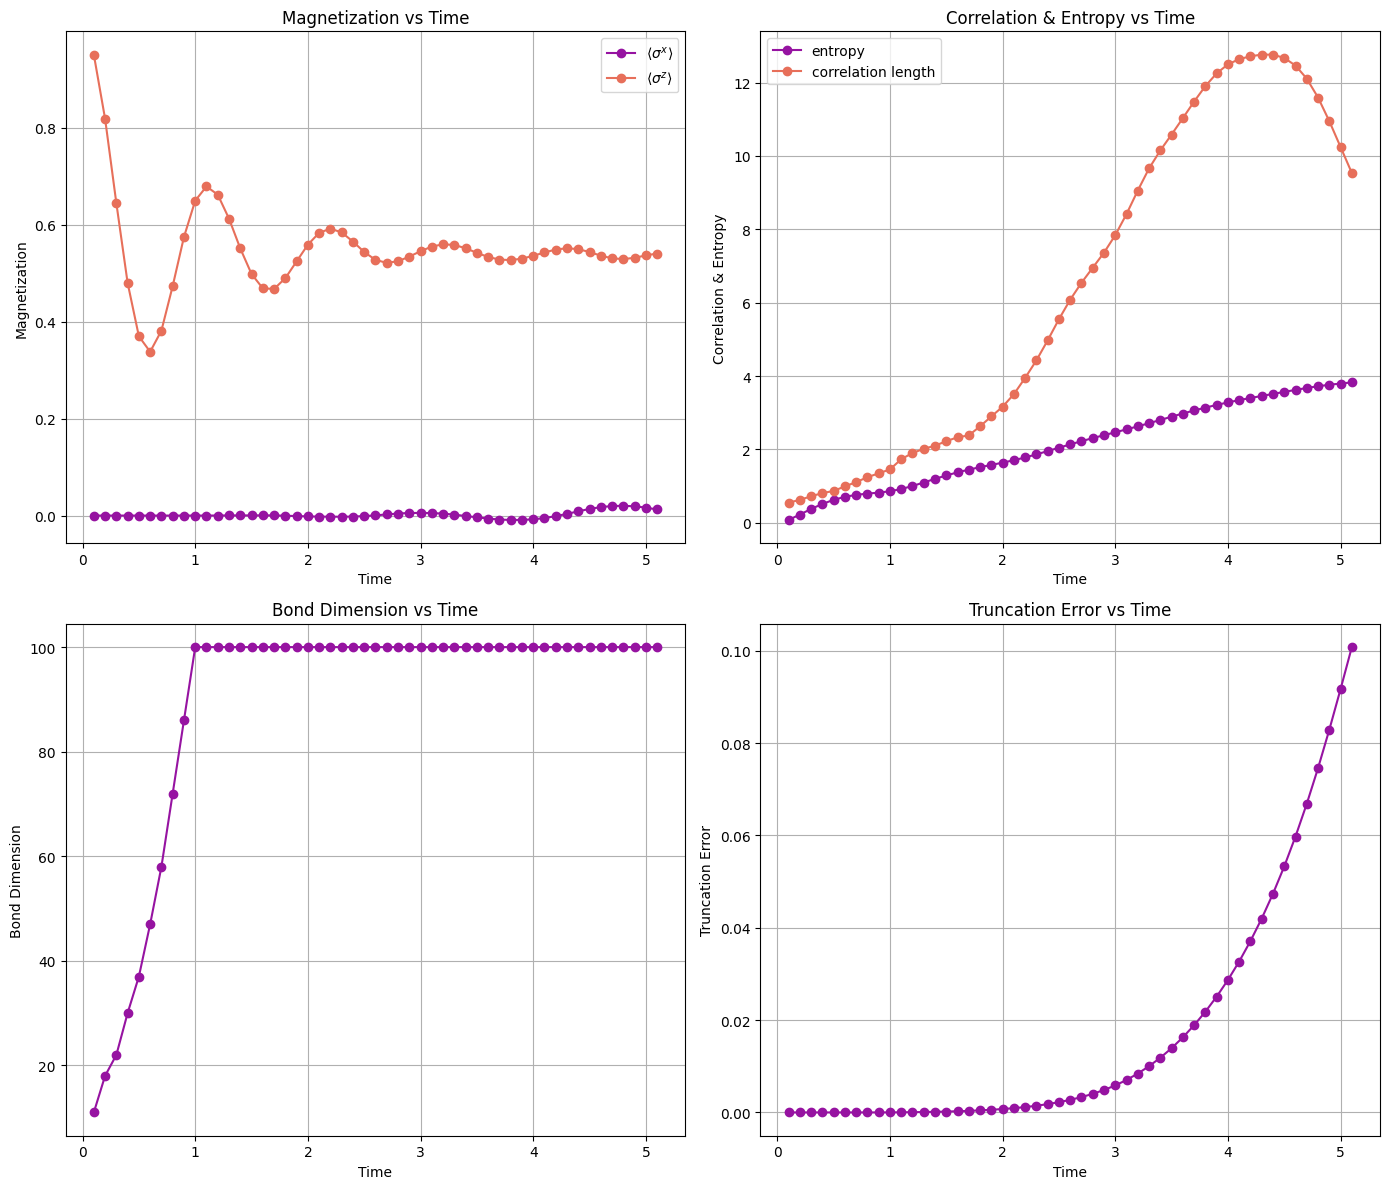

In [668]:
# Plot the time evolution results:
ExtIsingModelTimeEvolPlotter.plot_time_evolution(results10, "plasma")


#### **(c) Explain the behaviour of $\langle\sigma^{z}\rangle$ using algebraic reasoning.**

#### At $t=0$, since the state is $\ket{+}$ (an eigenstate of $\sigma^x$), one has $⟨σ^x⟩=1$. However, the Hamiltonian does not commute with $\sigma^x$(especially due to the $\sigma^z \sigma^z$ nd $\sigma^z$ terms), so under time evolution, the state picks up components in other directions. Using an algebraic argument, one can show that the expected values approximately should behave like:

$$ \frac{d}{dt} ⟨σ^z⟩ = i ⟨[H,σ^z]⟩ = - i \lambda \sum_i \Big( ⟨[\sigma_j^x,σ^z]⟩  + p ⟨[ \sigma_j^x \sigma_{j+1}^x,σ^z]⟩ \Big) \approx- i \lambda \sum_i \Big(\cancel{⟨σ_j^y⟩_+}  + p \cancel{⟨\sigma_{j}^z⟩_+} \Big) = 0$$ 

$$ \frac{d}{dt} ⟨σ^x⟩ = i ⟨[H,σ^x]⟩ = - i\sum_j  \Big(⟨[ \sigma_j^z \sigma_{j+1}^z,σ^x]⟩ + p ⟨[\sigma_j^z \sigma_{j+2}^z,σ^x]⟩ \Big) \approx - i (1+p) \sum_j  ⟨σ_j^x⟩ \ \rightarrow \ ⟨σ^x⟩ \approx e^{-ia(1+p)\cdot t} $$

#### (Notice the $\approx$, since the index don't match exactly, so its not an exact result, but just a quick intuition)

#### A more rigorous argument can be made, noticing that all the terms in the Hamiltonian are even in $\sigma^z \rightarrow -\sigma^z$, and also is the original $\ket{+}$ state, hence by symmetry we know exactly that $⟨σ^z⟩(t)=0$. For $\sigma^x \rightarrow -\sigma^x$ this is not the case, so we can't say, but generally we will have oscilations + decayment.

#### So $⟨σ^x⟩$ must change in time—typically exhibiting oscillatory and decayment behavior as the state “rotates” in Hilbert space under the competing terms in the Hamiltonian, and that $⟨σ^z⟩$ will remain constant (concretely 0, since it starts there with $\ket{+}$)


#### **(g) Discuss the relation between bond dimension growth, truncation error, and entanglement entropy**

#### As the quench drives the system out of equilibrium, entanglement builds up. In regions where the entanglement grows rapidly, the algorithm must increase the bond dimension to keep the truncation error low. If the bond dimension is capped at 100, eventually the truncation error will start to increase because the MPS cannot capture all the entanglement. Thus, there is a direct relation:

- **Bond Dimension ($D$) growth**: Signals increasing entanglement as time evolves, the system spreads its information. In this case at $t=1$, we reached the limit we set, starting to produce errors.
- **Truncation Error**: Remains low as long as $D$ is large enough; once the entanglement exceeds the capacity of the chosen bond dimension $D$ (at around $t\approx1s$), the error starts growing exponentially fast. 
- **Entanglement Entropy**: We see how it grows every time with less steepness, telling us that the information/entanglement/correlation spreads as the simulation starts, propagating with the interactions. Its growth is the driving force behind the increase in the needed bond dimension and eventual truncation errors.

#### This happens when the MPS algorithm truncates the Schmidt spectrum (i.e., discards the smaller Schmidt coefficients) to keep the bond dimension below a preset maximum, introducing a truncation error. This error quantifies the weight of the discarded Schmidt states. As entanglement increases, if the bond dimension is capped (or increased too slowly), a larger fraction of the state’s weight is discarded, leading to a higher truncation error.

#### In summary, monitoring these quantities you can know how good your simulation was:
- Growing Entanglement -> You will need Larger D
- Limited D -> Will create truncation error when reached

#### Soo maintain and accurate rep. the bond dimension must be increased as the entanglement rises, keeping the truncation error low. In our case, we could argue that after $t=1s$ the system start to lose fidelity. 

#### The last remark I wanted to say is, how quickly the Bond dimension increased to $D=100$, this shows how hard is to simulate dynamics of quantum systems, where entanglement and correlations move constantly everywhere with interactions.

### **3. Entanglement spectrum analysis** (1 point):

#### **(a) Compute the entanglement spectrum $e_{i}=-\log(\lambda_{i})$ where $\lambda_i$ are the eigenvalues of the reduced density matrix.**

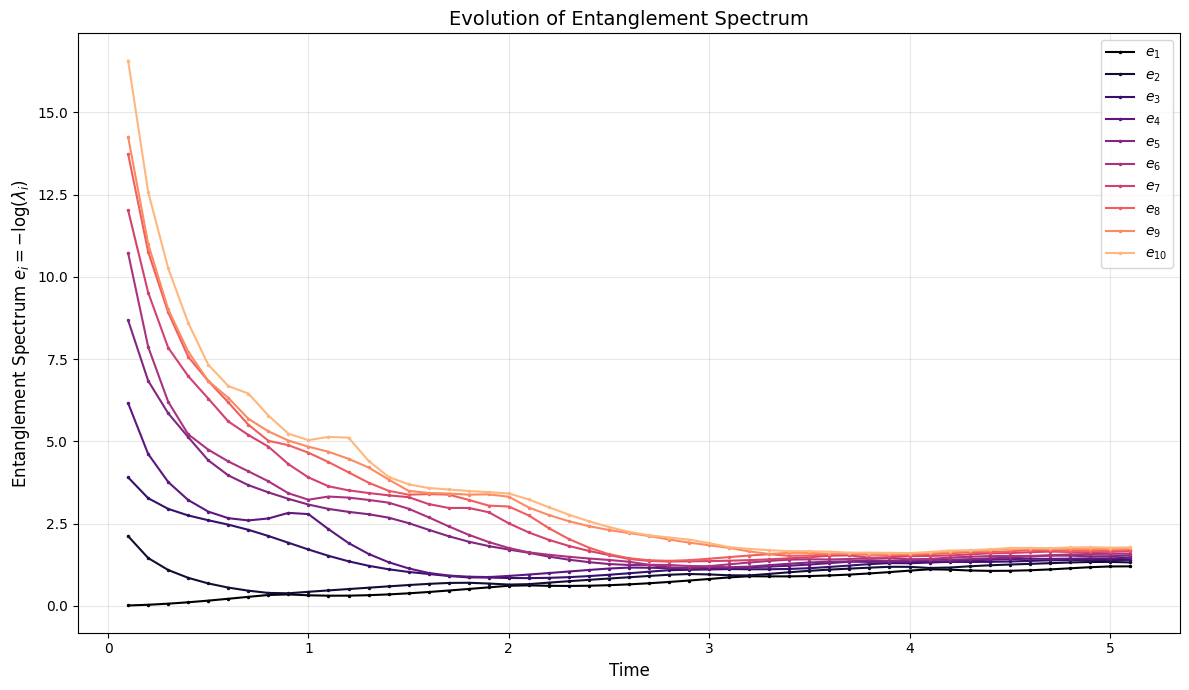

In [681]:
# Plotting the spectra against the time evolution for the model:
ExtIsingModelTimeEvolPlotter.plot_time_evolution_of_spectra(results10, "magma")

#### Which show how the high level states decay into the lower ones, which gain in value. While at the same time most of the spectra avoid the crossings, except the two bottom ones, that cross close to 1, 2, 3, 4 and so on..

    
#### **(b) Define gaps $\Delta_{i}=e_{i}-e_{0}$ for the $10$ largest eigenvalues and plot both $\Delta_{i}$ and their ratios $\Delta_{i}/\Delta_{1}$ as functions of time.**

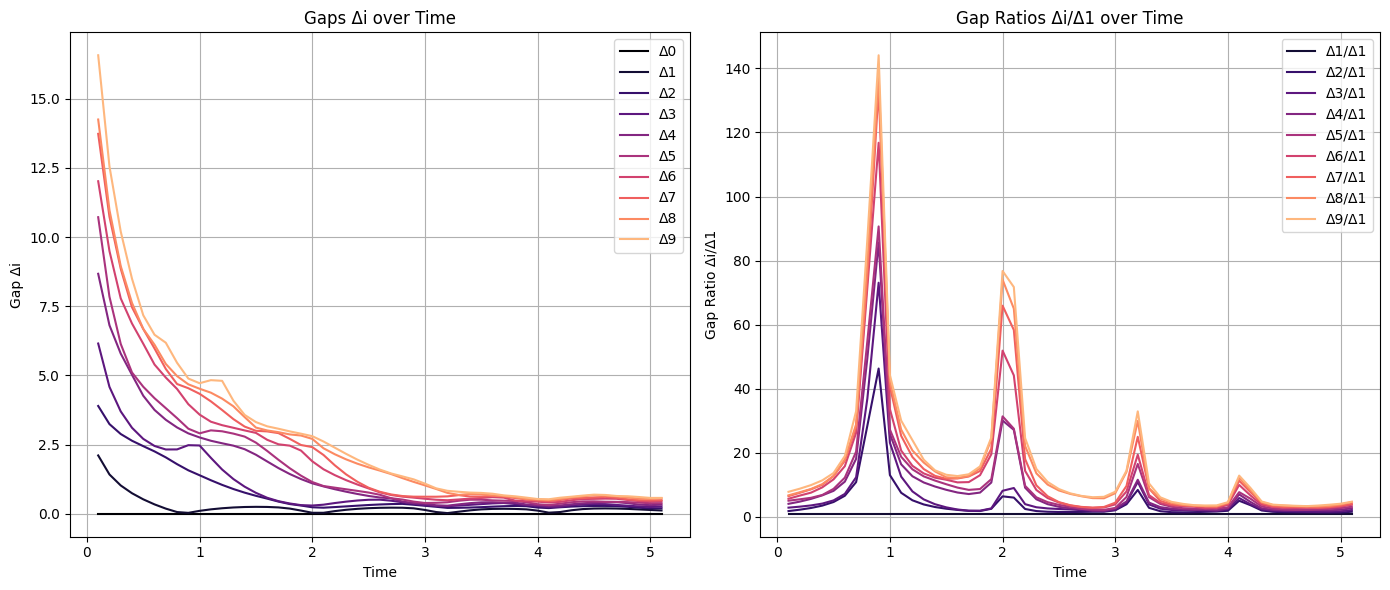

In [686]:
# Plotting the gaps against the time evolution for the model:
ExtIsingModelTimeEvolPlotter.plot_gaps_over_time(results10, "magma")

#### Which shows a again the periodic behaviour of the state 1, going low every $\approx 1s$ more ore less, each time with less strenght since the total value is increasing steadely.

#### And with with better granularity on `dt` (10 times denser), is:

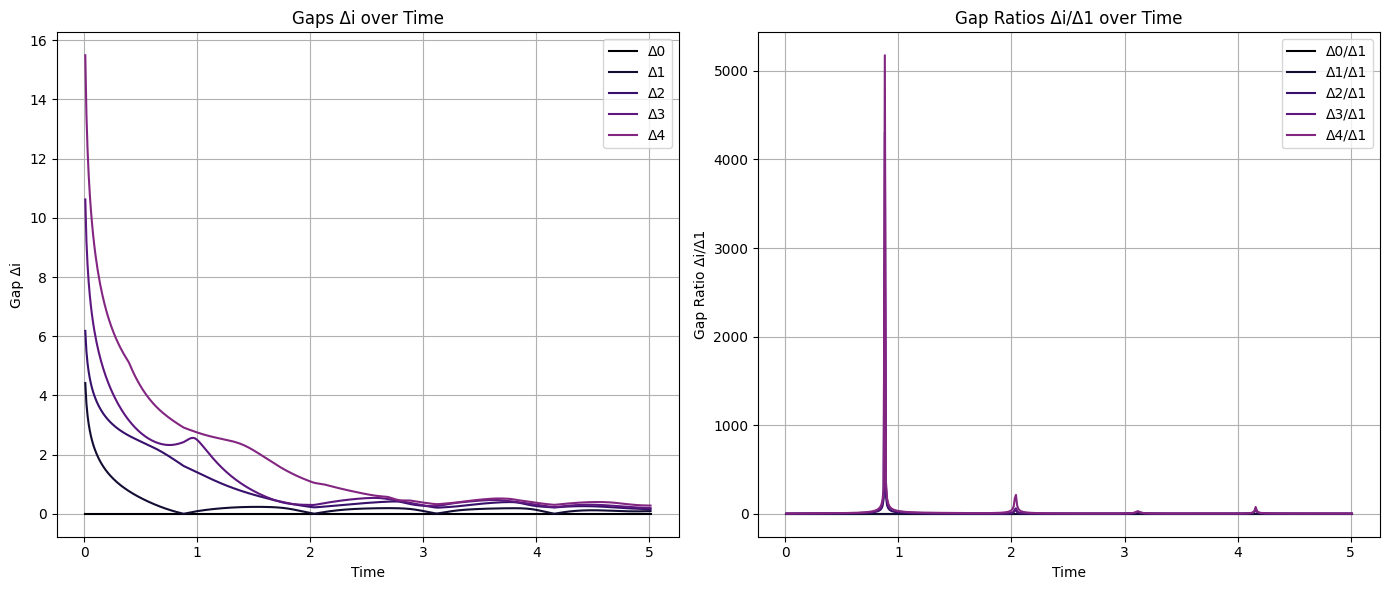

In [695]:
# Plotting the gaps against the time evolution for the model:
ExtIsingModelTimeEvolPlotter.plot_gaps_over_time(results11, "magma")

#### Where the better granularity catches better one of the crossing around $t\approx0.85$, making that Ratio diverge there.

### **4. Discussion** (0.5 points): Summarize and interpret results [5].

#### Repeting myself a bit in the Magnetization and Entanglement parts, but adding new discussions in the last 3 paragraphs:

#### Magnetization Dynamics:
At $t=0$, the system is fully polarized along $x$ (i.e. $⟨σ^x⟩=1$), and then under time evolution, due to the competing $zz$ interactions that do not commute with $σ^x$, the $⟨σ^x⟩(t)$ decays and oscillates. In contrast, $⟨σ^z⟩(t)$ starts and remains zero throughout the evolution, a consequence of the symmetry of both the Hamiltonian and the initial state.

#### Entanglement and Bond Dimension:
The entanglement entropy grows as the quench injects correlations into the system. When the entanglement becomes large, the MPS must increase its bond dimension to represent the state accurately. In our simulation, as the bond dimension approaches the cap of $D=100$, the truncation error begins to increase. This interplay indicates that the evolution is driving the system toward a more entangled state than can not be fully captured with only $D=100$.

#### Truncation Error:
A rising truncation error signals that significant weight is being discarded in the Schmidt decomposition. This is most pronounced when the entanglement entropy is high and the state develops many important Schmidt components. The growth of the bond dimension and the concurrent increase in the truncation error are two sides of the same coin: they both signal the buildup of quantum correlations.

#### Entanglement Spectrum:
Analyzing the entanglement spectrum reveals more detailed information about the structure of the correlations. The gaps $\Delta_i$ and their ratios $\Delta_i/\Delta_1$ can indicate the effective “energy scale” of the entanglement modes. For example, if the ratios remain nearly constant over time, this suggests that the overall structure of the entanglement is preserved, even as its overall scale (i.e. the absolute value of the gaps) changes. And in our case, as we can see in the more granulated final case, except for the divergences near the crossings, the rest of gap ratios are indeed always in a pretty constant height.


#### Overall, the quench drives the system out of equilibrium, causing oscillations in local observables, a rapid build‐up of entanglement, and a corresponding need for larger bond dimensions. When the maximum bond dimension is reached, the truncation error starts to grow, signaling that the MPS representation is beginning to lose accuracy. The entanglement spectrum analysis further provides insights into how the entanglement “levels” are organized and evolve in time.

#### These results demonstrate the rich non-equilibrium dynamics following the quench, where the interplay between local observables, entanglement growth, and limitations of the MPS representation (via bond dimension and truncation error) provides a comprehensive picture of how the system evolves. The observed behavior underscores the challenge of simulating long-time dynamics in highly entangled systems and highlights the importance of carefully monitoring these quantities to assess the simulation's accuracy.


## **IV. Summary**
#### **This assignment aims to deepen your understanding of quantum phase transitions and non-equilibrium dynamics using tensor network methods. Key takeaways include:**

- **Identifying quantum phases via correlation length scaling.**

- **Observing entanglement growth in quench dynamics.**
    
- **Understanding computational limitations imposed by bond dimension and truncation errors**


## References:

[1] F. C. Alcaraz, Phys. Rev. B **94**, 115116 (2016).

[2] J. Hauschild and F. Pollmann, SciPost Phys. Lect. Notes 005 (2018).

[3] J. Hauschild et al., $arXiv:2408.02010$ (2024).

[4] L. Tagliacozzo et al., Phys. Rev. B **78**, 024410 (2008).

[5] J. Surace et al., Phys. Rev. B **101**, 241107 (2020).
